# Check GPU

In [ ]:
!nvidia-smi

Thu Oct 20 03:14:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, utils, callbacks, applications
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from imutils import paths

# Load dataset

In [ ]:
CATEGORIES = ['heart', 'oblong', 'oval', 'round', 'square']
epochs=50
batch_size = 32
IMG_SIZE = 224

In [ ]:
trainDS = utils.image_dataset_from_directory(
    '/content/drive/MyDrive/CS331/data/train',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    color_mode='rgb',
)

testDS = utils.image_dataset_from_directory(
    '/content/drive/MyDrive/CS331/data/test',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    color_mode='rgb',
)

# Load pretrained model

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
pretrainedModel = applications.ResNet50(input_shape=IMG_SHAPE,
              include_top=False,
              weights='imagenet')
pretrainedModel.trainable = False
pretrainedModel.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

# Build model

In [ ]:
fullModel = keras.Sequential([
    layers.InputLayer(input_shape=IMG_SHAPE),

    pretrainedModel,
    
    layers.Flatten(),
    layers.Dense(5)
])

In [ ]:
fullModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 5)                 501765    
                                                                 
Total params: 24,089,477
Trainable params: 501,765
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
fullModel.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [ ]:
checkpointPath = "/content/drive/MyDrive/CS331/FromRaw/ResNet/checkpoint/model-{epoch:02d}-{val_accuracy:.2f}.h5"

In [ ]:
modelEarlyStopping = tf.keras.callbacks.EarlyStopping(
    min_delta=1e-5,
    patience=5,
    verbose=1,
    monitor='val_loss',
    restore_best_weights=False,
)

modelCheckpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpointPath,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose = 1,
    mode='max'
)


# Train model

In [ ]:
with tf.device('/gpu:0'):
    history = fullModel.fit(
            trainDS,
            validation_data=testDS,
            epochs=epochs,
            callbacks = [modelEarlyStopping, modelCheckpoint]
    )

Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 2.3854 - accuracy: 0.3410
Epoch 1: val_accuracy improved from -inf to 0.42142, saving model to /content/drive/MyDrive/CS331/FromRaw/ResNet/checkpoint/model-01-0.42.h5
125/125 [==============================] - 1139s 8s/step - loss: 2.3854 - accuracy: 0.3410 - val_loss: 1.9324 - val_accuracy: 0.4214
Epoch 2/50
125/125 [==============================] - ETA: 0s - loss: 0.6455 - accuracy: 0.7688
Epoch 2: val_accuracy improved from 0.42142 to 0.44645, saving model to /content/drive/MyDrive/CS331/FromRaw/ResNet/checkpoint/model-02-0.45.h5
125/125 [==============================] - 30s 231ms/step - loss: 0.6455 - accuracy: 0.7688 - val_loss: 1.8499 - val_accuracy: 0.4464
Epoch 3/50
125/125 [==============================] - ETA: 0s - loss: 0.2231 - accuracy: 0.9461
Epoch 3: val_accuracy did not improve from 0.44645
125/125 [==============================] - 29s 226ms/step - loss: 0.2231 - accuracy: 0.9461 - val_loss: 1.805

# Plot loss and accuracy

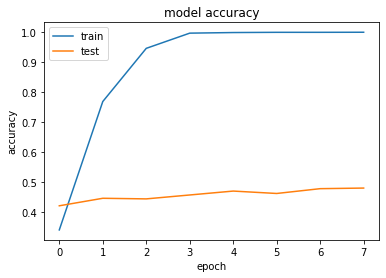

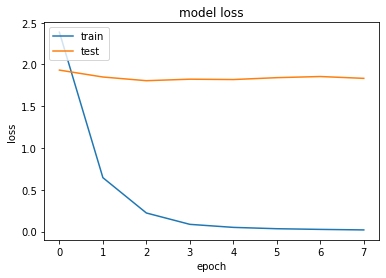

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Test model

In [ ]:
def loadData(path):
    imagePaths = list(paths.list_images(path))
    data = []
    labels = []

    for imagePath in tqdm(imagePaths):
        label = imagePath.split(os.path.sep)[-2]
        # Read image
        image = cv2.imread(imagePath)

        # Resize
        imageResize = cv2.resize(image, (224,224))


        data.append(imageResize)
        labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    lb = LabelEncoder()
    labels = lb.fit_transform(labels)
    return data, labels

In [ ]:
xTest, yTest = loadData(('/content/drive/MyDrive/CS331/data/test'))

100%|██████████| 1000/1000 [03:55<00:00,  4.25it/s]


In [ ]:
newModel = keras.models.load_model('/content/drive/MyDrive/CS331/FromRaw/ResNet/checkpoint/model-08-0.48.h5')

In [ ]:
zScores = newModel.predict(xTest)
yPred = np.argmax(zScores, axis=1)
corrects = (yTest == yPred).sum()
print(f'Model predict {corrects}/{len(yTest)} corrects')

32/32 [==============================] - 12s 94ms/step
Model predict 405/1000 corrects


## Confusion matrix

Text(114.0, 0.5, 'Truth')

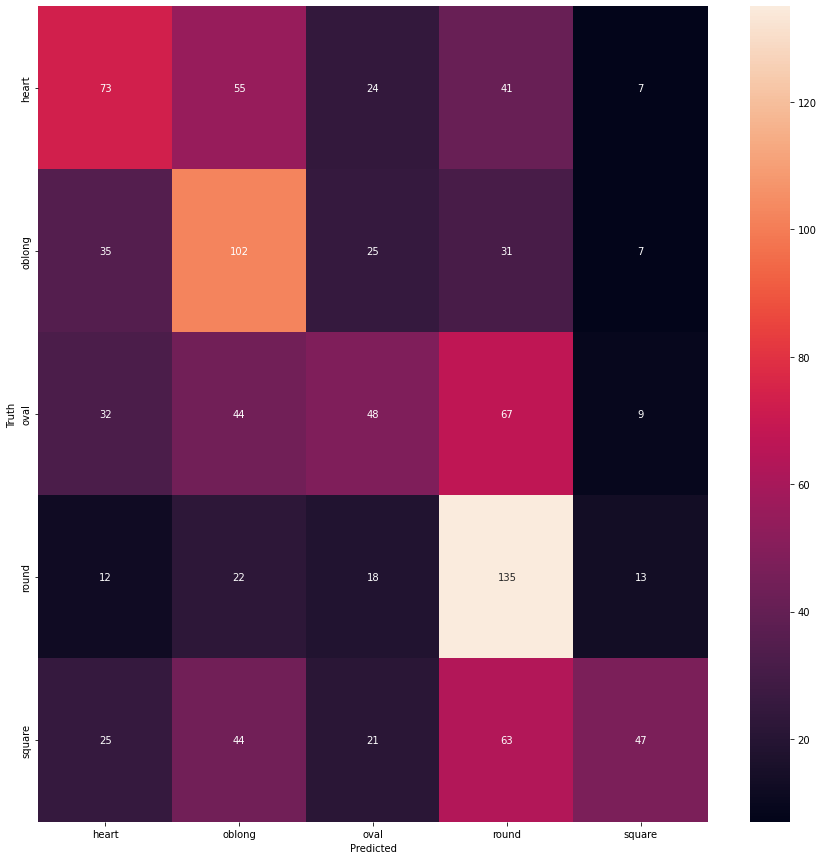

In [ ]:
cm = tf.math.confusion_matrix(labels=yTest, predictions=yPred)
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['heart', 'oblong', 'oval', 'round', 'square'],
            yticklabels=['heart', 'oblong', 'oval', 'round', 'square'],
            )
plt.xlabel('Predicted')
plt.ylabel('Truth')

## Classification report

In [ ]:
print(classification_report(yTest, yPred,target_names=['heart', 'oblong', 'oval', 'round', 'square']))

              precision    recall  f1-score   support

       heart       0.41      0.36      0.39       200
      oblong       0.38      0.51      0.44       200
        oval       0.35      0.24      0.29       200
       round       0.40      0.68      0.50       200
      square       0.57      0.23      0.33       200

    accuracy                           0.41      1000
   macro avg       0.42      0.40      0.39      1000
weighted avg       0.42      0.41      0.39      1000

